# Geospatial Analysis of Housing Data (Brasília - DF)

## 🏙️ Context

When we think about **buying or renting a property**, it’s common to consider factors such as **price, location, size, number of bedrooms, bathrooms, and parking spaces**. Often, when browsing real estate websites, we automatically associate the **property value** with the **area where it is located** — especially in Brasília, where neighborhoods like **Asa Sul, Asa Norte, and Jardim Botânico** have very distinct value perceptions.

But does the **price of a property depend only on its physical characteristics**, such as size and number of rooms? Or does **geographical location also play a significant role** in determining its value?

Moreover, an important question arises: could the **presence of certain nearby amenities**, such as **parks, shopping centers, schools, hospitals, or leisure areas**, contribute to **increasing the property’s value**?

In this study, we aim to investigate whether these factors truly manifest in the context of **Brasília’s real estate market**. By the end, we will seek to answer these two fundamental questions and understand **which elements most influence property values** in the capital city.

---

## 🗺️ Step 1: Load the boundaries of Brasília and the real estate dataset

To begin our analysis, we will load **the official geographic boundaries of the Federal District** and **the dataset containing real estate listings in Brasília**.

The **territorial boundaries** will be obtained directly from the **official IBGE repository**, which provides updated municipal shapefiles for all regions of Brazil. This layer will serve as a **spatial reference** to identify which properties are truly located within the administrative limits of the Federal District.
The **real estate data**, on the other hand, were collected from a **real estate listings website** and stored in a CSV file containing information such as price, number of bedrooms, bathrooms, parking spaces, and geographic coordinates (latitude and longitude).

Before moving on to exploration, it’s essential to perform a **thorough data cleaning**, since real estate datasets often contain **incorrect or inconsistent records**. Common issues include:

* Properties with **coordinates outside the Federal District boundaries**;
* Records with **missing values (`NaN`)** in key fields;
* **Unrealistic prices** — either extremely high or low compared to the market average.

To ensure our analysis is accurate, we will follow these steps:

1. **Remove records with missing values** in critical fields such as latitude, longitude, and price;
2. **Convert the dataset into a GeoDataFrame** to enable spatial operations using the coordinates;
3. **Filter only the properties located within the official polygon of the Federal District**, using the IBGE geometry as a spatial mask.

After completing this step, we will have a **clean and geographically consistent dataset**, ready for further analysis — including spatial visualization and exploration of the factors that influence real estate prices in Brasília.


✅ Official geographic boundary of the Federal District successfully loaded!


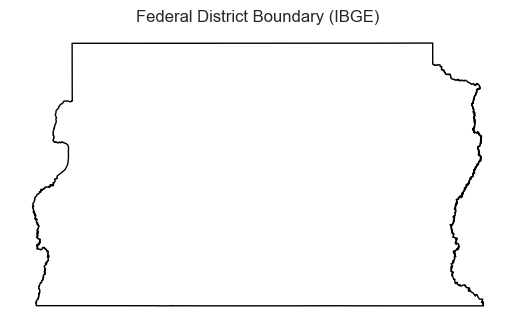

📄 Sample of the original dataset:


,aceita_pets,aquecimento_solar,ar_condicionado,area_lazer,area_servico,area_util,bairro,caracteristicas,cidade,cidade_bairro,...,salao_jogos,sauna,script_lat_long,spa,suites,url,vagas,valor,varanda,vista_livre
0,0,1,0,1,1,194.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,1,0,NaN,1,1.0,https://www.dfimoveis.com.br/imovel/lancamento...,1.0,NaN,1,1
1,0,1,0,1,1,600.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,0,NaN,1,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,6.0,15500000.0,1,1
2,0,0,0,0,0,126.0,ASA NORTE,NaN,BRASÍLIA,BRASÍLIA - ASA NORTE,...,0,0,NaN,0,1.0,https://www.dfimoveis.com.br/imovel/apartament...,1.0,1600000.0,0,0
3,1,0,1,0,1,590.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,1,NaN,0,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,4.0,3490000.0,1,0
4,0,1,0,1,1,77.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,0,1,NaN,0,2.0,https://www.dfimoveis.com.br/imovel/lancamento...,2.0,NaN,1,0


✅ 13636 records remaining after removing missing values.
✅ 13466 properties are located within the Federal District boundaries.
🧹 Unnecessary columns removed. 
Remaining columns: ['aceita_pets', 'aquecimento_solar', 'ar_condicionado', 'area_lazer', 'area_servico', 'area_util', 'bairro', 'cond_valor', 'cozinha_com_armarios', 'cozinha_espacosa', 'despensa', 'escritorio', 'gas_canalizado', 'gerador_energia', 'guarita', 'home_theater', 'interfone', 'jardim', 'lavabo', 'lazer_no_pilotis', 'mobiliado', 'pintura_nova', 'piscina', 'piso_porcelanato', 'playground', 'portao_eletronico', 'projeto_iluminacao', 'quadra_poliesportiva', 'quartos', 'sala_ginastica', 'salao_festas', 'salao_gourmet', 'salao_jogos', 'sauna', 'spa', 'suites', 'vagas', 'valor', 'varanda', 'vista_livre', 'geometry']
🧹 Removed 1 records where 'bairro' was 'selecione'.


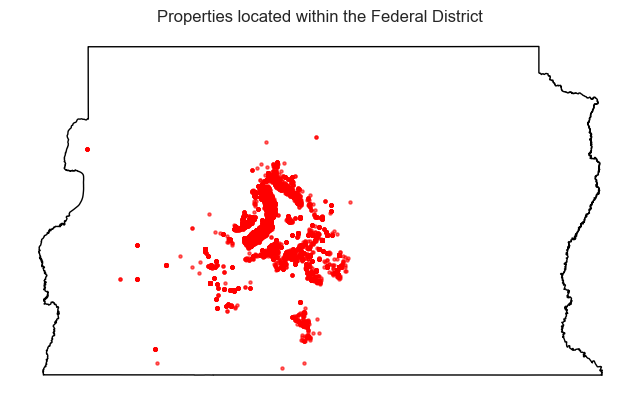

💾 File successfully exported to: REAL_STATE_DATA\properties_DF.geojson
Total properties exported: 13465


In [57]:
from random import random

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================
# 1. Load the official boundary of the Federal District (IBGE)
# ==========================

BRASILIA_IBGE_URL = (
    "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/"
    "malhas_municipais/municipio_2024/UFs/DF/DF_UF_2024.zip"
)

REAL_ESTATE_CSV = "REAL_STATE_DATA/brasilia.csv"
OUTPUT_DIR = "REAL_STATE_DATA"

# Load the Federal District polygon
df_poly = gpd.read_file(BRASILIA_IBGE_URL)
print("✅ Official geographic boundary of the Federal District successfully loaded!")

# Visualize the polygon
df_poly.plot(edgecolor='black', facecolor='none')
plt.title("Federal District Boundary (IBGE)")
plt.axis('off')
plt.show()


# ==========================
# 2. Load real estate data
# ==========================
df = pd.read_csv(REAL_ESTATE_CSV)

print("📄 Sample of the original dataset:")
display(df.head())


# ==========================
# 3. Initial cleaning: remove missing values
# ==========================
df = df.dropna(subset=["latitude", "longitude", "valor"])
print(f"✅ {len(df)} records remaining after removing missing values.")


# ==========================
# 4. Convert properties into a GeoDataFrame
# ==========================
gdf_properties = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)


# ==========================
# 5. Filter properties located WITHIN the Federal District polygon
# ==========================
mask = gdf_properties.within(df_poly.union_all())
properties_df = gdf_properties[mask].copy()

print(f"✅ {len(properties_df)} properties are located within the Federal District boundaries.")


# ==========================
# 6. Remove unnecessary columns
# ==========================
columns_to_drop = [
    'longitude', 'latitude', 'cidade_bairro', 'data_coleta', 'descricao',
    'caracteristicas', 'script_lat_long', 'cidade', 'imovel', 'preco', 'url'
]
properties_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"🧹 Unnecessary columns removed. \nRemaining columns: {list(properties_df.columns)}")

# ==========================
# 🚫 Remove invalid neighborhood entries
# ==========================

if "bairro" in properties_df.columns:
    before = len(properties_df)
    properties_df = properties_df[properties_df["bairro"].str.lower() != "selecione"].copy()
    after = len(properties_df)
    print(f"🧹 Removed {before - after} records where 'bairro' was 'selecione'.")
else:
    print("⚠️ Column 'bairro' not found in dataset.")


# ==========================
# 7. Visualize valid properties
# ==========================
fig, ax = plt.subplots(figsize=(8, 8))
df_poly.plot(ax=ax, color='white', edgecolor='black')
properties_df.plot(ax=ax, markersize=5, color='red', alpha=0.6)
plt.title("Properties located within the Federal District")
plt.axis('off')
plt.show()


# ==========================
# 8. Export filtered properties
# ==========================
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "properties_DF.geojson")

properties_df.to_file(output_path, driver="GeoJSON")

print(f"💾 File successfully exported to: {output_path}")
print(f"Total properties exported: {len(properties_df)}")



## 📊 Step 2: Exploratory Analysis of Geospatial Data

Now that we have a **clean and geographically consistent real estate dataset**, we can begin the **exploratory data analysis (EDA)**.
At this stage, the goal is to understand the **behavior of property values** in relation to the available variables in the dataset — **without yet considering external factors** such as proximity to parks, schools, or hospitals.

The exploratory analysis aims to answer questions such as:

* What are the **most common price ranges** among properties in Brasília?
* Is there a relationship between the **property value and the number of bedrooms, bathrooms, or parking spaces**?
* Are there **asymmetric distributions** (for example, a few very expensive properties pulling the average upward)?
* How does the **price per square meter** behave across the available records?

Before moving on to more complex models or spatial analyses, it’s important to ensure that the data is well understood and that there are no extreme outliers or inconsistencies that could distort the results.

In this stage, we will:

1. **Visualize descriptive statistics** (mean, median, standard deviation, and quartiles) of the main attributes;
2. **Graphically analyze the distribution of property values** through histograms and boxplots;
3. **Explore correlations** between price and other quantitative variables such as total area, number of bedrooms, bathrooms, and parking spaces;
4. **Calculate the price per square meter**, a useful metric for standardizing comparisons between properties of different sizes.

These analyses will help identify initial patterns, such as possible linear relationships between variables and the general behavior of the real estate market in the Federal District — serving as a foundation for later stages, where we will incorporate the **geographic component** (proximity to services and urban infrastructure).


In [58]:
import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
import os

# Set font that supports emojis
plt.rcParams["font.family"] = "Segoe UI Emoji"

# Output directory
OUTPUT_DIR_STATS = "ANALISYS_DATA/"
os.makedirs(OUTPUT_DIR_STATS, exist_ok=True)

output_path = os.path.join(OUTPUT_DIR_STATS, "summary_statistics.png")

# Descriptive statistics
desc = properties_df.describe().T

# Format numbers and round values
desc_styled = (
    desc.style
    .format("{:,.2f}")
    .set_caption("📊 Summary Statistics of Property Dataset")
    .background_gradient(cmap="Blues")
    .set_table_styles(
        [
            {"selector": "caption",
             "props": [("font-size", "16px"), ("font-weight", "bold"),
                       ("text-align", "left"), ("color", "#2E86C1")]},
            {"selector": "th",
             "props": [("background-color", "#1B2631"),
                       ("color", "white"), ("text-align", "center")]},
        ]
    )
)

# Export the styled DataFrame as a PNG image
dfi.export(desc_styled, output_path, table_conversion="matplotlib")

print(f"✅ Table successfully exported to: {output_path}")

display(desc_styled)


✅ Table successfully exported to: ANALISYS_DATA/summary_statistics.png


,count,mean,std,min,25%,50%,75%,max
aceita_pets,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
aquecimento_solar,"13,465.00",0.10,0.29,0.00,0.00,0.00,0.00,1.00
ar_condicionado,"13,465.00",0.24,0.42,0.00,0.00,0.00,0.00,1.00
area_lazer,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
area_servico,"13,465.00",0.30,0.46,0.00,0.00,0.00,1.00,1.00
area_util,"13,465.00",725.34,"5,890.17",0.00,75.14,233.40,563.00,"470,178.00"
cond_valor,"7,218.00","1,908.28","39,095.27",0.00,457.25,671.00,"1,106.00","2,100,000.00"
cozinha_com_armarios,"13,465.00",0.26,0.44,0.00,0.00,0.00,1.00,1.00
cozinha_espacosa,"13,465.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00
despensa,"13,465.00",0.14,0.35,0.00,0.00,0.00,0.00,1.00


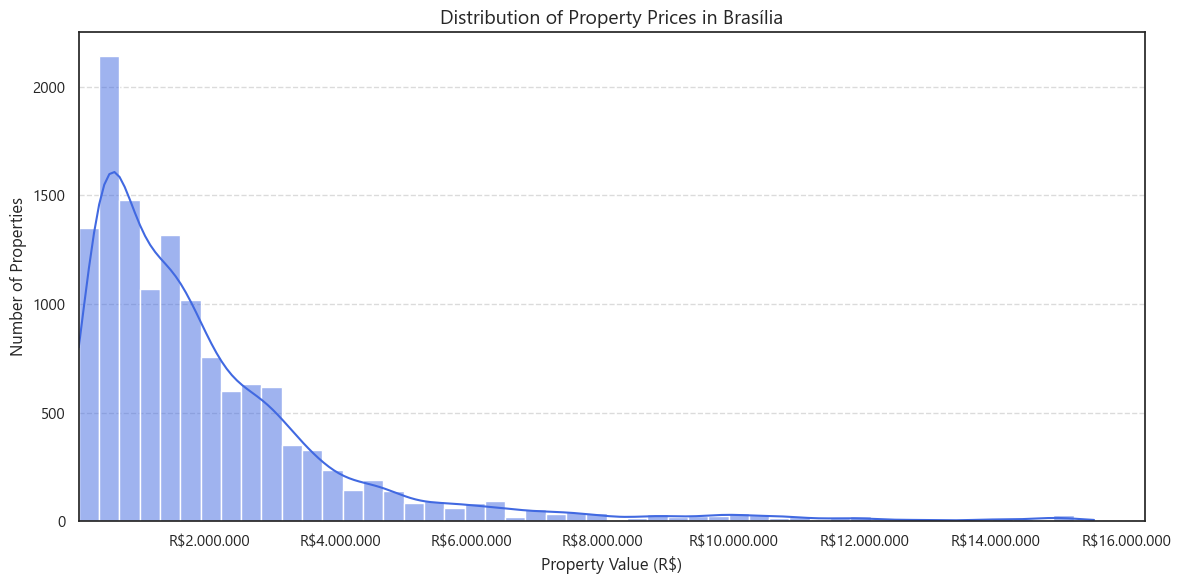

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

# Ensure that 'valor' is numeric
properties_df["valor"] = pd.to_numeric(properties_df["valor"], errors="coerce")

# Remove missing or non-positive values (for visualization only; do not mutate the original DataFrame)
filtered_df = properties_df[properties_df["valor"] > 0]

# Define the upper limit (exclude outliers above the 99th percentile)
upper_limit = np.percentile(filtered_df["valor"], 99)
filtered_data = filtered_df[filtered_df["valor"] <= upper_limit]

# Determine the minimum actual value (to start the x-axis exactly there)
min_value = filtered_data["valor"].min()

# Create histogram
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    filtered_data["valor"],
    bins=50,
    kde=True,
    color="royalblue"
)

# Title and labels
plt.title("Distribution of Property Prices in Brasília", fontsize=14, fontweight="bold")
plt.xlabel("Property Value (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)

# Formatter to display values in Brazilian real (R$) on the X-axis
formatter = mticker.FuncFormatter(lambda x, pos: f"R${x:,.0f}".replace(",", "."))
ax.xaxis.set_major_formatter(formatter)

# Improve spacing and grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(left=min_value)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_STATS}/property_value_distribution.png')
plt.show()

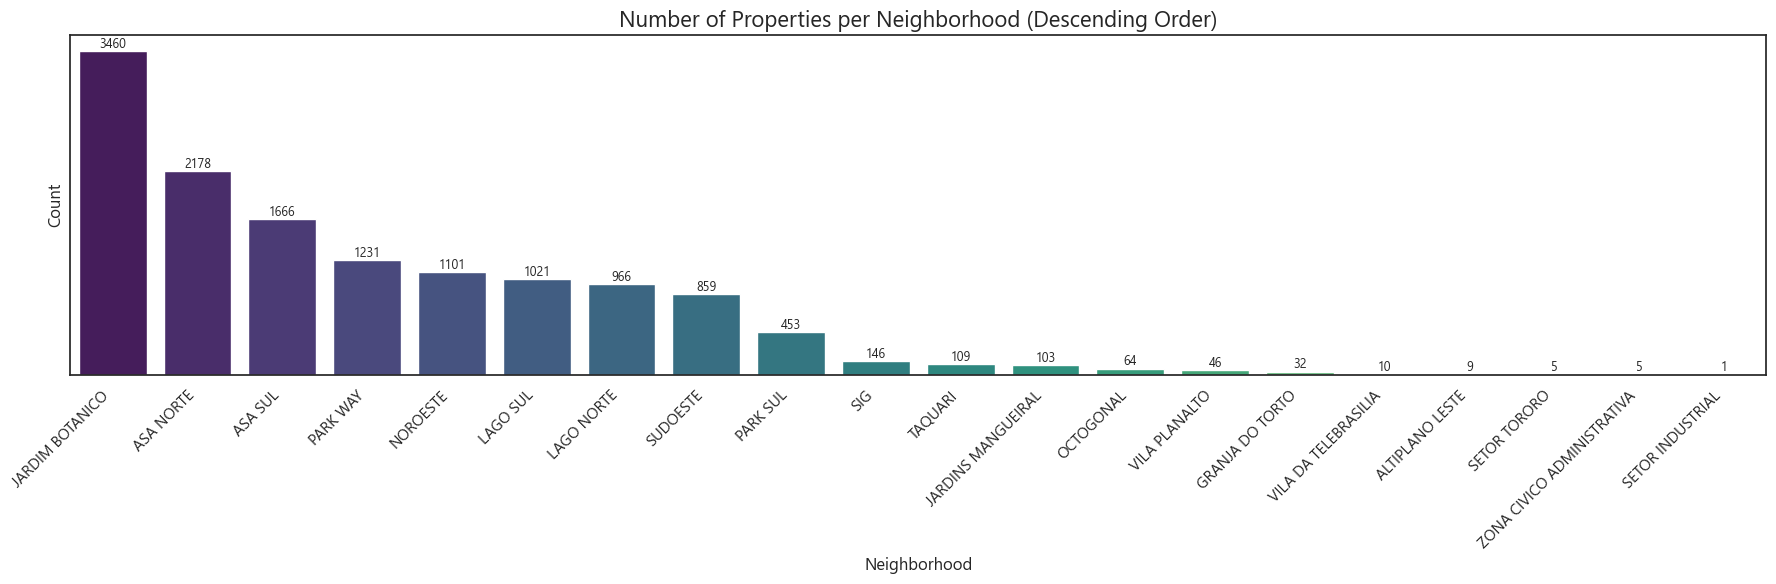

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'valor' is float
properties_df["valor"] = properties_df["valor"].astype(float)

# Count properties per neighborhood (manual naming to avoid duplicates)
bairro_counts = (
    properties_df["bairro"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "bairro", 0: "count"})
)

# Just in case, drop duplicated columns if they exist
bairro_counts = bairro_counts.loc[:, ~bairro_counts.columns.duplicated()]

# Sort descending
bairro_counts = bairro_counts.sort_values(by="count", ascending=False)

# Plot
plt.figure(figsize=(18, 6))
ax = sns.barplot(
    data=bairro_counts,
    x="bairro",
    y="count",
    palette="viridis",
    hue='bairro',
)

# Add labels above bars
for i, v in enumerate(bairro_counts["count"]):
    ax.text(i, v + 1, str(v), ha="center", va="bottom", fontsize=9)

# Formatting
plt.xticks(rotation=45, ha="right")
plt.title("Number of Properties per Neighborhood (Descending Order)", fontsize=16, fontweight="bold")
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.yticks([])
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_STATS}/neighborhood_count.png')
plt.show()

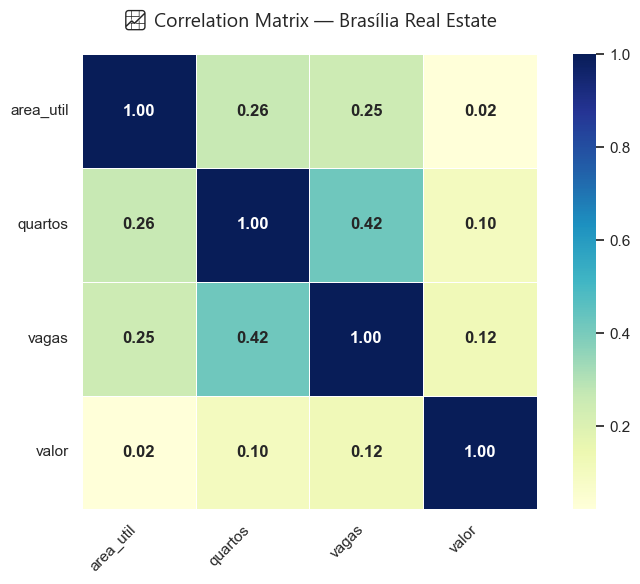

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
cols = ["area_util", "quartos", "vagas", "valor"]
corr = properties_df[cols].corr(method="pearson")

# Create figure
plt.figure(figsize=(8, 6))
sns.set(style="white")

# Create heatmap with annotations and elegant colors
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 12, "weight": "bold"},
)

# Title and visual adjustments
plt.title("📈 Correlation Matrix — Brasília Real Estate", fontsize=14, weight="bold", pad=20, fontname="Segoe UI Emoji")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_STATS}/corr_matrix.png')
plt.show()

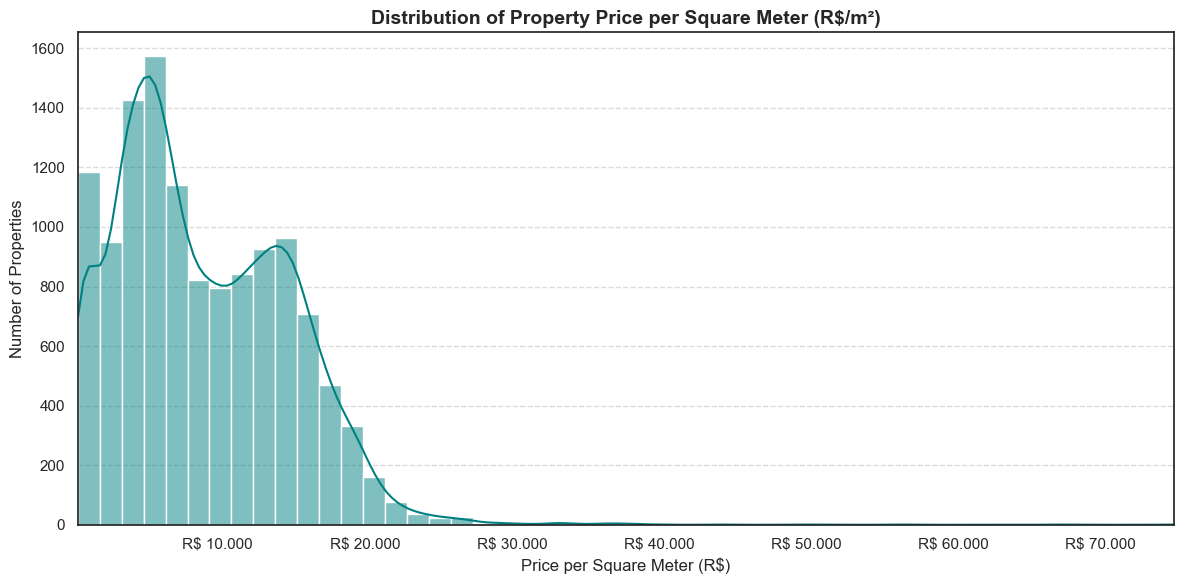

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Calculate price per square meter
properties_df["preco_m2"] = properties_df["valor"] / properties_df["area_util"]

# Ensure the 'preco_m2' field exists and is clean
properties_df = properties_df[(properties_df["preco_m2"] > 500) & (properties_df["preco_m2"] < 80000)]

# Create the histogram
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    properties_df["preco_m2"],
    bins=50,
    kde=True,
    color="teal"
)

# Format X-axis with thousand separator and R$ symbol
formatter = mticker.FuncFormatter(lambda x, pos: f"R$ {x:,.0f}".replace(",", "."))
ax.xaxis.set_major_formatter(formatter)

# Adjust limits and labels
plt.xlim(left=properties_df["preco_m2"].min(), right=properties_df["preco_m2"].max())
plt.title("Distribution of Property Price per Square Meter (R$/m²)", fontsize=14, fontweight="bold")
plt.xlabel("Price per Square Meter (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_STATS}/property_price_distribution.png')
plt.show()

#### 💡 Interpretation of Results and Next Steps

From the analyses conducted so far, it is clear that **none of the quantitative variables alone** — such as usable area, number of bedrooms, bathrooms, or parking spaces — are strong enough to fully explain the variation in property values in Brasília. This suggests that **property prices are influenced by more than just physical characteristics**.

One important observation is the presence of **multicollinearity** among some variables — that is, variables that are highly correlated with each other. For instance, the number of bedrooms and the number of suites show a strong positive correlation, indicating that properties with more bedrooms also tend to have more suites. While this makes sense conceptually, such overlap can reduce the model’s ability to isolate the unique impact of each variable on price.

Another key finding concerns the **distribution of property prices**, which is **right-skewed (positively asymmetric)**. This means that a small number of high-priced properties pull the average upward, while most properties are concentrated in lower price ranges. This kind of asymmetry makes simple linear modeling less effective, since linear regression assumes normally distributed residuals.

---

## 📊 Step 3: Building Predictive Models for Property Values

These challenges, however, **do not prevent us from building predictive models** that can better capture the complexity of the real estate market. To address this, we will apply three distinct modeling approaches — each with a specific purpose and analytical depth:

1. **Simple Linear Regression**
   This model will attempt to predict property values based on a few key variables that are intuitively related to price. The goal is to establish a baseline understanding — even if it may not be fully accurate — of how certain features relate to value.

2. **Multiple Linear Regression (with p-value analysis)**
   In this model, we will include a broader set of variables and analyze their statistical significance through *p-values*. This will allow us to objectively identify which features truly contribute to price prediction and which do not. While we might temporarily exclude some variables with low significance, they will be kept for future verification or different analytical contexts.

3. **Random Forest Regressor**
   Finally, we will use a Random Forest model to capture **nonlinear relationships and complex interactions** between variables. This algorithm is robust against asymmetry, outliers, and multicollinearity, making it well-suited for the irregular patterns of the real estate market. It will also help identify which variables are most influential in determining property prices.

To evaluate the performance of each model, we will use standardized metrics:

* **MAE (Mean Absolute Error)**
* **RMSE (Root Mean Squared Error)**
* **R² (Coefficient of Determination)**

These metrics will allow us to **compare accuracy consistently** and determine which approach performs best in predicting property values in Brasília.
By using these benchmarks, we aim to make **data-driven, coherent, and transparent decisions** about which modeling strategy offers the best balance between interpretability and predictive power — a critical step toward understanding and forecasting property prices in the Federal District.

#### Model 1: Simple Linear Regression — Evaluating Property Values

📈 Model Evaluation Metrics:
Mean Absolute Error (MAE): R$ 1,411,894.02
Root Mean Squared Error (RMSE): R$ 3,001,925.51
R² Score: 0.2370


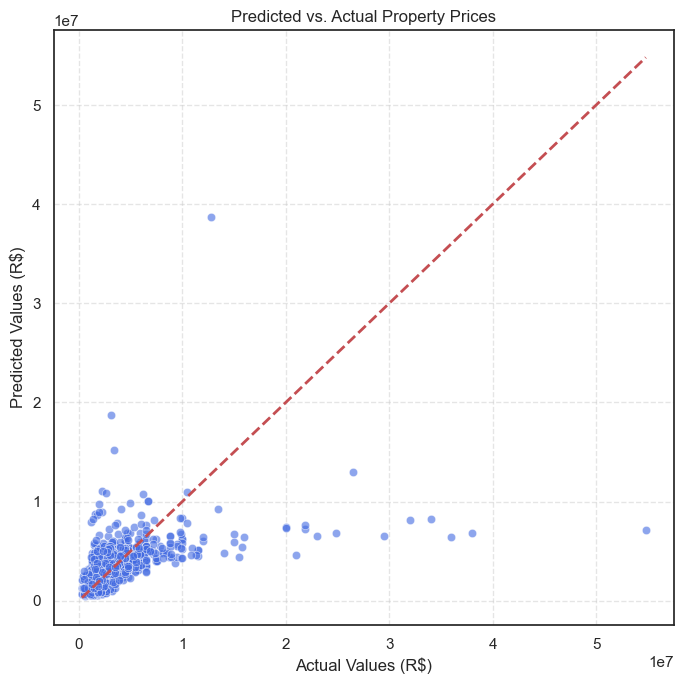


💡 Feature Importance (Linear Coefficients):


,Feature,Coefficient
0,area_util,1.195386e+06
2,suites,9.049991e+05
3,vagas,3.834490e+05
4,pintura_nova,2.318520e+05
1,quartos,-1.663170e+05


In [63]:
# ======================================================
# 🧠 Linear Regression Model — Evaluating Property Prices
# ======================================================
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)

# Output directory
OUTPUT_DIR_MODELS = "MODEL_RESULTS/"
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# Select relevant features
features = ["area_util", "quartos", "suites", "vagas", "pintura_nova"]
target = "valor"

# Remove records with missing values
data_model = properties_df[features + [target]].dropna()

# Separate features (X) and target (y)
X = data_model[features]
y = data_model[target]

# Scale the data for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): R$ {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): R$ {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Compare actual vs. predicted values
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Values (R$)")
plt.ylabel("Predicted Values (R$)")
plt.title("Predicted vs. Actual Property Prices")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_MODELS}/linear_regression_actual_vs_predicted.png', dpi=300)
plt.show()

# Display model coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n💡 Feature Importance (Linear Coefficients):")
display(coef_df)

#### Model 2: Multiple Linear Regression with p-value Analysis

In [64]:
# ======================================================
# 🧠 Multiple Linear Regression with p-value Analysis
# ======================================================

import statsmodels.api as sm

# Select explanatory variables (excluding 'bairro' and 'geometry' as they are categorical/geometric)
cols = [
    'aceita_pets', 'aquecimento_solar', 'ar_condicionado', 'area_lazer',
    'area_servico', 'area_util', 'cond_valor', 'cozinha_com_armarios',
    'cozinha_espacosa', 'despensa', 'escritorio', 'gas_canalizado',
    'gerador_energia', 'guarita', 'home_theater', 'interfone', 'jardim',
    'lavabo', 'lazer_no_pilotis', 'mobiliado', 'pintura_nova', 'piscina',
    'piso_porcelanato', 'playground', 'portao_eletronico', 'projeto_iluminacao',
    'quadra_poliesportiva', 'quartos', 'sala_ginastica', 'salao_festas',
    'salao_gourmet', 'salao_jogos', 'sauna', 'spa', 'suites', 'vagas',
    'varanda', 'vista_livre', 'preco_m2'
]

# Ensure that all selected columns exist in the dataset and are numeric
available_cols = [c for c in cols if c in properties_df.columns]
data = properties_df[available_cols + ['valor']].dropna()

# Define dependent and independent variables
X = data[available_cols]
y = data['valor']

# Add constant term (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Display full summary
print(model.summary())

# Export model summary to a .txt file (optional)
with open(f"{OUTPUT_DIR_MODELS}/model_summary.txt", "w", encoding="utf-8") as f:
    f.write(model.summary().as_text())

print(f"📄 Model summary saved to {OUTPUT_DIR_MODELS}/model_summary.txt")

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     126.7
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:52:58   Log-Likelihood:                -58267.
No. Observations:                3785   AIC:                         1.166e+05
Df Residuals:                    3745   BIC:                         1.169e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.641e+06 

#### Model 3: Random Forest Regressor — Predicting Property Values

📊 Model Evaluation:
MAE  (Mean Absolute Error): R$ 83,410.94
RMSE (Root Mean Square Error): R$ 272,633.74
R²   (Coefficient of Determination): 0.981


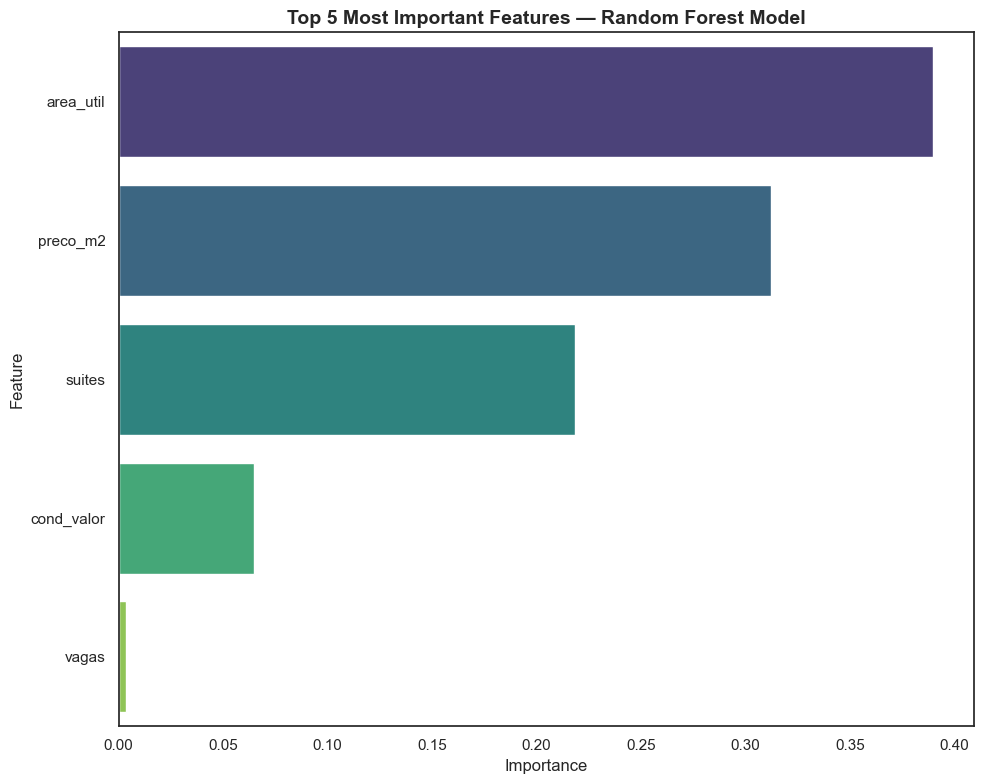

In [65]:
# ======================================================
# 🌲 Random Forest Regressor — Predicting Property Values
# ======================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Select predictive features (excluding geometry and text columns)
features = [
    'aceita_pets', 'aquecimento_solar', 'ar_condicionado', 'area_lazer',
    'area_servico', 'area_util', 'cond_valor', 'cozinha_com_armarios',
    'cozinha_espacosa', 'despensa', 'escritorio', 'gas_canalizado',
    'gerador_energia', 'guarita', 'home_theater', 'interfone', 'jardim',
    'lavabo', 'lazer_no_pilotis', 'mobiliado', 'pintura_nova', 'piscina',
    'piso_porcelanato', 'playground', 'portao_eletronico', 'projeto_iluminacao',
    'quadra_poliesportiva', 'quartos', 'sala_ginastica', 'salao_festas',
    'salao_gourmet', 'salao_jogos', 'sauna', 'spa', 'suites', 'vagas',
    'varanda', 'vista_livre', 'preco_m2'
]

# Ensure that all columns exist and are numeric
available_features = [f for f in features if f in properties_df.columns]
df_model = properties_df[available_features + ['valor']].dropna()

X = df_model[available_features]
y = df_model['valor']

# 2️⃣ Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3️⃣ Train the model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4️⃣ Evaluate model performance
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation:")
print(f"MAE  (Mean Absolute Error): R$ {mae:,.2f}")
print(f"RMSE (Root Mean Square Error): R$ {rmse:,.2f}")
print(f"R²   (Coefficient of Determination): {r2:.3f}")

# 5️⃣ Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 6️⃣ Visualize top features
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importances.head(5),
    x='Importance',
    y='Feature',
    palette='viridis',
    hue='Feature',
)
plt.title('Top 5 Most Important Features — Random Forest Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR_MODELS}/randomforest_feature_importance.png")
plt.show()



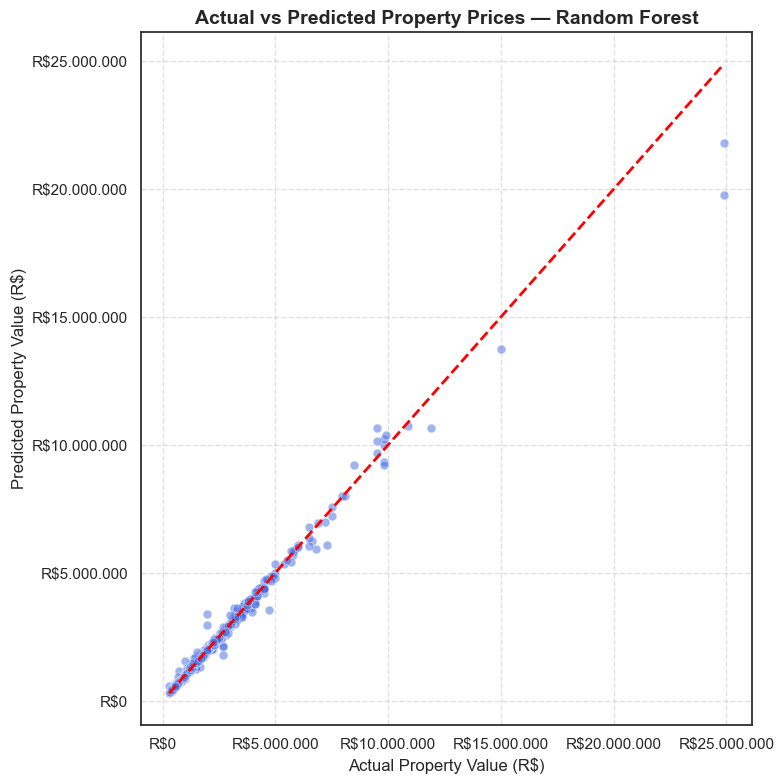

In [66]:
# ======================================================
# 📊 Actual vs. Predicted Plot — Random Forest
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="royalblue", s=40)

# Ideal line (y = x)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2)

# Title and labels
plt.title("Actual vs Predicted Property Prices — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Actual Property Value (R$)", fontsize=12)
plt.ylabel("Predicted Property Value (R$)", fontsize=12)

# Format axis values in Brazilian Real (thousands/millions)
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f"R${x:,.0f}".replace(",", "."))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR_MODELS}/randomforest_real_vs_pred.png", dpi=300)
plt.show()


#### 📊 **Model Comparison — Property Value Prediction (Brasília)**

| Model                                |      MAE (R\$) |     RMSE (R\$) | R² Score  | Interpretation                                                                              |
| ------------------------------------ |---------------:|---------------:|:---------:| ------------------------------------------------------------------------------------------- |
| **Linear Regression (Simple)**       | 1,411,894.02   |   3,001,925.51 |  0.2370   | Baseline model — captures general trends but limited explanatory power.                     |
| **Multiple Linear Regression (OLS)** |              — |              — | **0.569** | Explains about 60% of price variability; significant variables identified through p-values. |
| **Random Forest Regressor**          |  **83,410.94** | **272,633.74** | **0.981** | Excellent predictive accuracy; captures nonlinear patterns and complex interactions.        |

💡 **Insights:**

* The **OLS model** improves explanatory power compared to the simple regression, highlighting important features like *usable area*, *suites*, and *vagas* (parking spaces).
* The **Random Forest model** dramatically increases predictive performance (R² ≈ 0.98), showing it can **capture complex, nonlinear relationships** that linear models miss.
* However, Random Forest sacrifices interpretability — while it predicts very well, it’s harder to explain *why* certain features matter most.

#### 📊 **Comparative Evaluation of Regression Models**

💡 **Interpretation**

* The **Random Forest model** shows **superior performance**, achieving the lowest errors and the highest R² score, indicating that it explains nearly all the variance in property values.
* The **Multiple Linear Regression** improves over the simple model but is still constrained by its linear assumptions and multicollinearity issues.
* The **Simple Linear Regression** serves as a baseline, highlighting that physical characteristics alone (like area, rooms, and parking) are insufficient to predict property prices accurately.

---

### 🏠 **Conclusion: What Really Defines Property Prices in Brasília?**

From the analyses carried out, we can conclude that **property prices in Brasília are not determined only by physical characteristics**, such as usable area, number of bedrooms, suites, or parking spaces.

The linear regression models showed that, while these features have some influence on price, **they only explain part of the variation** in property values. This suggests that other factors, beyond the internal attributes of the property, play a big role in determining prices.

The **Random Forest Regressor** model performed very well overall, showing strong predictive power and low error rates. However, it’s important to note that this model — as applied here — **did not explicitly take geographic location into account**. It used only tabular variables, without considering coordinates, neighborhoods, or spatial distances.

So, even though the Random Forest was able to capture complex relationships between features like area, number of suites, swimming pool, and finish quality, **it didn’t actually “understand” where each property is located** — which is a key element in how real estate prices are formed.

There is, however, an **indirect geographical influence**, especially through correlated variables such as **price per square meter**, which tends to reflect the difference between more and less valued areas. But this effect is only an approximation — it doesn’t replace true spatial variables.

In short, the value of a property **depends not only on what it is, but also on where it is**. Proximity to upscale neighborhoods, access to services, infrastructure quality, environmental factors, and even symbolic aspects like prestige or safety all strongly shape housing prices — yet these elements still need to be added explicitly to the model.

The next step will be to **include geographic and contextual variables** (like latitude, longitude, distance to the city center, and proximity to schools, hospitals, or parks). This will allow us to better understand **how location influences property values** and how urban space shapes the real estate market in Brasília.

---

## 🗺️ Step 4: Adding Geospatial Features to the Model

So far, we’ve reached **partial answers** to our main questions. To move forward, we now need to include **geospatial variables** in our predictive model to better understand what drives property prices in Brasília.

The next step will be to **load new datasets** with information about the **location of important points of interest** — such as hospitals, schools, parks, and shopping centers. After adding these spatial features, we’ll analyze whether **proximity to these amenities has a real impact on property values**.

We expect that including these new variables will help us **build stronger and more complete conclusions**, providing a clearer picture of how location and accessibility influence real estate prices in the Federal District.


In [67]:
# ======================================================
# 🌍 Download and Extract OSM Data — Centro-Oeste Region
# ======================================================
import requests
import zipfile
import os

# Create directory for geospatial data
OUTPUT_DIR_GEO = "GEO_DATA"
os.makedirs(OUTPUT_DIR_GEO, exist_ok=True)

# URL for OSM data (Centro-Oeste region)
url_link_OSM = "https://download.geofabrik.de/south-america/brazil/centro-oeste-251111-free.shp.zip"

# Paths for download and extraction
zip_path = f"{OUTPUT_DIR_GEO}/centro-oeste_OSM.zip"
extract_path = f"{OUTPUT_DIR_GEO}/"

# Download the OSM ZIP file
print("⬇️ Downloading OSM data for Centro-Oeste region...")
response = requests.get(url_link_OSM, stream=True)

# Save the file
with open(zip_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

print("✅ Download completed!")

# Extract the ZIP file
print("📦 Extracting files...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Remove the ZIP file
os.remove(zip_path)
print("🧹 ZIP file removed after extraction.")

print(f"✅ OSM data for Centro-Oeste region is ready in the {OUTPUT_DIR_GEO} folder!")

⬇️ Downloading OSM data for Centro-Oeste region...
✅ Download completed!
📦 Extracting files...
🧹 ZIP file removed after extraction.
✅ OSM data for Centro-Oeste region is ready in the GEO_DATA folder!


In [68]:
# ===============================================================
# 🚉 Download and Save Subway and BRT Geospatial Layers (Brasília)
# ===============================================================

import geopandas as gpd
import os

# URLs from ArcGIS Hub
URL_METRO = (
    "https://hub.arcgis.com/api/v3/datasets/92e10066030f40d49059830656ba67a9_0/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)
URL_BRT = (
    "https://hub.arcgis.com/api/v3/datasets/1dabe88927e84464bf62d928b1972ed5_2/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)


# File paths
METRO_PATH = os.path.join(OUTPUT_DIR_GEO, "metro_brasilia.geojson")
BRT_PATH = os.path.join(OUTPUT_DIR_GEO, "brt_brasilia.geojson")

# Load data directly from URL
print("⬇️ Downloading Metrô data...")
gdf_metro = gpd.read_file(URL_METRO)
print(f"✅ Metrô data loaded! {len(gdf_metro)} features found.")

print("⬇️ Downloading BRT data...")
gdf_brt = gpd.read_file(URL_BRT)
print(f"✅ BRT data loaded! {len(gdf_brt)} features found.")

# Save to GeoJSON files
gdf_metro.to_file(METRO_PATH, driver="GeoJSON")
gdf_brt.to_file(BRT_PATH, driver="GeoJSON")

print(f"💾 Files saved successfully in '{OUTPUT_DIR_GEO}'!")
print(f"- Metrô: {METRO_PATH}")
print(f"- BRT: {BRT_PATH}")


⬇️ Downloading Metrô data...
✅ Metrô data loaded! 29 features found.
⬇️ Downloading BRT data...
✅ BRT data loaded! 10 features found.
💾 Files saved successfully in 'GEO_DATA'!
- Metrô: GEO_DATA\metro_brasilia.geojson
- BRT: GEO_DATA\brt_brasilia.geojson


In [69]:
buildings = "GEO_DATA/gis_osm_buildings_a_free_1.shp"
POIS = "GEO_DATA/gis_osm_pois_free_1.shp"
POIS_A = "GEO_DATA/gis_osm_pofw_a_free_1.shp"
PLACES_A = "GEO_DATA/gis_osm_places_a_free_1.shp"
PLACES = "GEO_DATA/gis_osm_places_free_1.shp"
TRANSPORT_A = "GEO_DATA/gis_osm_transport_a_free_1.shp"
TRANSPORT = "GEO_DATA/gis_osm_transport_free_1.shp"
gdf_buildings = gpd.read_file(buildings)
gdf_pois = gpd.read_file(POIS)
gdf_pois_A = gpd.read_file(POIS_A)
gdf_places_A = gpd.read_file(PLACES_A)
gdf_places = gpd.read_file(PLACES)
gdf_transport_A = gpd.read_file(TRANSPORT_A)
gdf_transport = gpd.read_file(TRANSPORT)


In [70]:
gdf_transport

,osm_id,code,fclass,name,geometry
0,142334966,5621,bus_stop,612 Norte,POINT (-47.88153 -15.74814)
1,142335073,5621,bus_stop,Ponto de Ônibus do CEAN,POINT (-47.876 -15.76568)
2,142335237,5621,bus_stop,604 Norte - Carmen Salles,POINT (-47.87421 -15.77621)
3,303847107,5601,railway_station,Brasília,POINT (-47.941 -15.77547)
4,319069265,5661,ferry_terminal,None,POINT (-57.23504 -19.25838)
...,...,...,...,...,...
5498,13286599493,5621,bus_stop,"EPCT, km 79,4 norte",POINT (-48.05828 -15.813)
5499,13286599494,5621,bus_stop,"EPCT, km 79 norte",POINT (-48.05765 -15.81669)
5500,13286599495,5621,bus_stop,"EPCT, km 80,4 norte",POINT (-48.05747 -15.80393)
5501,13286639386,5621,bus_stop,"N 3, QNO 09",POINT (-48.12392 -15.80078)
